In [5]:
import sys
sys.path.append("..")
from utilities import defaultPlotting

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib_venn import venn2, venn2_circles

In [41]:
estimate = (pd.read_csv(
    '../../GM12878/testChr11/alleleEstimate/snpsplit/GM12878-snpsplit.txt', header=None, sep=',').squeeze())

true = (pd.read_csv(
    '../../GM12878/testChr11/alleleTrue/snpsplit/GM12878-snpsplit.txt', header=None, sep=',').squeeze())

In [94]:
defaultPlotting(width=90, size=12, ratio=1)

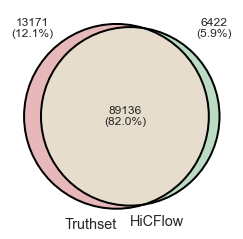

In [97]:
fig, ax = plt.subplots(1)

subsets = [set(true.tolist()), set(estimate.tolist())]
total = len(subsets[0].union(subsets[1]))
labels = ['Truthset', 'HiCFlow']

vd = venn2(subsets=subsets, set_labels=labels, 
            subset_label_formatter=lambda x: f'{x}\n({(x / total):1.1%})', ax=ax)
venn2_circles(subsets=subsets, linewidth=2, ax=ax)
vd.get_label_by_id('10').set_y(0.52)
vd.get_label_by_id('01').set_y(0.52)

fig.tight_layout()
fig.savefig(f'phasing-overlap.pdf')

In [69]:
labels = (formatCell('GM12878'), formatCell('IMR90'), formatCell('H1hESC'))

In [70]:
names = [('chrom',''), ('start',''), ('end',''), ('nASTAD',''), ('allNormal',''), ('minScore','')]
names2 = []
for cell in labels:
    for name in ['chrom', 'start', 'end', 'type', 'score', 'CNV', 'High_Signal_Region', 'Low_Mappability']:
        names.append((cell, f'{name}'))
        names2.append(f'{cell}-{name}')
names.extend([('High_Signal_Region',''), ('Low_Mappability','')])

conserved = (
    a.intersect(b, f=fraction, r=True, wb=True)
    .intersect(c, f=fraction, r=True, wb=True)
    .to_dataframe(names=names2))

conserved['chrom'] = conserved[[f'{cell}-chrom' for cell in labels]].min(axis=1)
conserved['start'] = conserved[[f'{cell}-start' for cell in labels]].min(axis=1)
conserved['end'] = conserved[[f'{cell}-end' for cell in labels]].max(axis=1)
conserved['nASTAD'] = (conserved[[f'{cell}-type' for cell in labels]] == 'ASTAD').sum(axis=1)
conserved['allNormal'] = (conserved[[f'{cell}-CNV' for cell in labels]] == 'Normal').all(axis=True)
conserved['minScore'] = conserved[[f'{cell}-score' for cell in labels]].min(axis=1)

# Move columns to start of table
for name in ['minScore', 'allNormal', 'nASTAD', 'end', 'start', 'chrom']:
    col = conserved.pop(name)
    conserved.insert(0, name, col)
                                  
conserved = processBlacklist(conserved)
conserved['High_Signal_Region'] = conserved['High_Signal_Region'].fillna(0)
conserved['Low_Mappability'] = conserved['Low_Mappability'].fillna(0)

conserved.columns = names
conservedASTADs = conserved.loc[conserved[('nASTAD','')] == 3]

dropCols = []
for cell in labels:
    for name in ['chrom', 'start', 'end', 'type']:
        conservedASTADs = conservedASTADs.drop((cell, name), axis=1)

# Read gencode and imprinted genes for overlap analysis
genes = ({
    'allGenes': BedTool.from_dataframe(pd.read_pickle(
        '../1.ASE_and_Imprinted/gencode.v38lift37-genes.pkl')),
    'Imprinted': BedTool.from_dataframe(pd.read_pickle(
        '../1.ASE_and_Imprinted/gencode.v38lift37-imprinted.pkl'))
})

conserved.columns = pd.MultiIndex.from_tuples(conserved.columns)
conservedASTADs.columns = pd.MultiIndex.from_tuples(conservedASTADs.columns)

with pd.ExcelWriter(f'overlapStats.xlsx') as writer:
    conservedASTADs.sort_values('minScore', ascending=False).to_excel(writer, sheet_name='conserved-ASTADs')
    conserved.sort_values('minScore', ascending=False).to_excel(writer, sheet_name='allOverlapData')
    
    rename = ({
        'name': 'Gene ID', 'strand': 'orientation', 
        'thickStart': 'Gene Type', 'thickEnd': 'Symbol'
    })
    for geneStatus, geneBed in genes.items():
        geneOverlap = (
            geneBed.intersect(BedTool.from_dataframe(conservedASTADs), u=True)
            .to_dataframe().rename(rename, axis=1))
        (geneOverlap[['chrom', 'start', 'end', 'orientation', 'Symbol', 'Gene ID', 'Gene Type']]
         .to_excel(writer, sheet_name=geneStatus))        

In [71]:
conserved.to_pickle('conservedTADs.pkl')

In [72]:
subsets = (
    a_not_b_not_c, b_not_c_not_a, a_and_b_not_c, c_not_b_not_a, 
    a_and_c_not_b, b_and_c_not_a, a_and_b_and_c)
total = sum(subsets)

subsetsAS = (
    a_not_b_not_cAS, b_not_c_not_aAS, a_and_b_not_cAS, c_not_b_not_aAS, 
    a_and_c_not_bAS, b_and_c_not_aAS, a_and_b_and_cAS)
totalAS = sum(subsetsAS)

In [73]:
defaultPlotting(width=90, ratio=1)

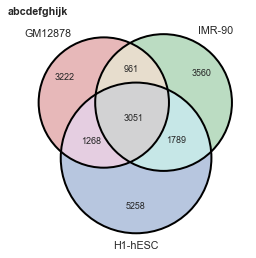

In [74]:
fig, ax = plt.subplots()
venn3(subsets=subsets, set_labels=labels, ax=ax)
venn3_circles(subsets=subsets, linewidth=2, ax=ax)

fig.tight_layout()
ax.text(0, 1, 'abcdefghijk', transform=fig.transFigure, fontsize='large', verticalalignment='top', weight='bold')
fig.savefig(f'plots/TAD-overlap.svg')

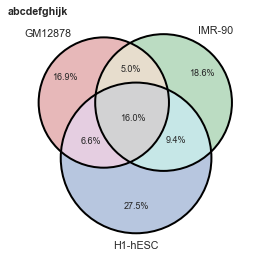

In [75]:
fig, ax = plt.subplots()
venn3(subsets=subsets, set_labels=labels, 
      subset_label_formatter=lambda x: f'{(x / total):1.1%}', ax=ax)
venn3_circles(subsets=subsets, linewidth=2, ax=ax)

fig.tight_layout()
ax.text(0, 1, 'abcdefghijk', transform=fig.transFigure, fontsize='large', verticalalignment='top', weight='bold')
fig.savefig(f'plots/TAD-overlap-percent.svg')

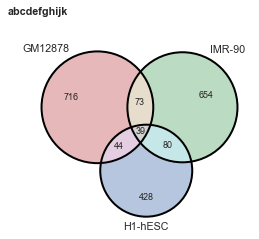

In [76]:
fig, ax = plt.subplots()
venn3(subsets=subsetsAS, set_labels=labels, ax=ax)
venn3_circles(subsets=subsetsAS, linewidth=2, ax=ax)

fig.tight_layout()
ax.text(0, 1, 'abcdefghijk', transform=fig.transFigure, fontsize='large', verticalalignment='top', weight='bold')
fig.savefig(f'plots/ASTAD-overlap.svg')

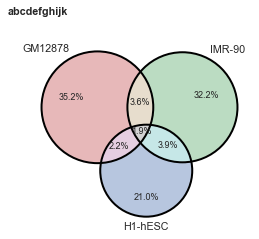

In [77]:
fig, ax = plt.subplots()
venn3(subsets=subsetsAS, set_labels=labels, 
      subset_label_formatter=lambda x: f'{(x / totalAS):1.1%}', ax=ax)
venn3_circles(subsets=subsetsAS, linewidth=2, ax=ax)

fig.tight_layout()
ax.text(0, 1, 'abcdefghijk', transform=fig.transFigure, fontsize='large', verticalalignment='top', weight='bold')
fig.savefig(f'plots/ASTAD-overlap-percent.svg')

In [78]:
# For overlap analysis we only want to consider "normal" TADs
aAS = (
    aAS.intersect('../annotation/hg19-blacklist.bed', wa=True, v=True)
    .intersect('../0.processCNV/GM12878-CNV-nonNormal.bed', wa=True, v=True))

bAS = (
    bAS.intersect('../annotation/hg19-blacklist.bed', wa=True, v=True)
    .intersect('../0.processCNV/IMR90-CNV-nonNormal.bed', wa=True, v=True))

cAS = (
    cAS.intersect('../annotation/hg19-blacklist.bed', wa=True, v=True)
    .intersect('../0.processCNV/H1hESC-CNV-nonNormal.bed', wa=True, v=True))

In [79]:
nA = aAS.count()
nB = bAS.count()
nC = cAS.count()

# Get observed count
a_and_bObs, a_and_cObs, b_and_cObs = intersectBoth(aAS, bAS, cAS, fraction)
a_and_b_and_cObs = a_and_bObs.intersect(cAS, f=fraction, r=True, wb=True).count()
ABobs = a_and_bObs.count()
ACobs = a_and_cObs.count()
BCobs = b_and_cObs.count()
ABCobs = a_and_b_and_cObs

TADOverlap = {}
TADOverlap [f'{formatCell("GM12878")} & {formatCell("IMR90")}'] = ABobs
TADOverlap [f'{formatCell("GM12878")} & {formatCell("H1hESC")}'] = ACobs
TADOverlap [f'{formatCell("IMR90")} & {formatCell("H1hESC")}'] = BCobs
TADOverlap ['3-Way Overlap'] = ABCobs

In [81]:
allShuffles = defaultdict(list)
for i in range(1000):
    Asample = BedTool.from_dataframe(a.to_dataframe().sample(nA)).sort()
    Bsample = BedTool.from_dataframe(b.to_dataframe().sample(nB)).sort()
    Csample = BedTool.from_dataframe(c.to_dataframe().sample(nC)).sort()
    
    a_and_bSample, a_and_cSample, b_and_cSample = intersectBoth(Asample, Bsample, Csample, fraction)
    a_and_b_and_cSample = a_and_bSample.intersect(Csample, f=fraction, r=True, wb=True).count()
    
    allShuffles[f'{formatCell("GM12878")} & {formatCell("IMR90")}'].append(a_and_bSample.count())
    allShuffles[f'{formatCell("GM12878")} & {formatCell("H1hESC")}'].append(a_and_cSample.count())
    allShuffles[f'{formatCell("IMR90")} & {formatCell("H1hESC")}'].append(b_and_cSample.count())
    allShuffles['3-Way Overlap'].append(a_and_b_and_cSample)

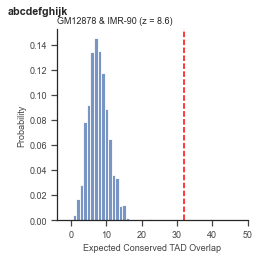

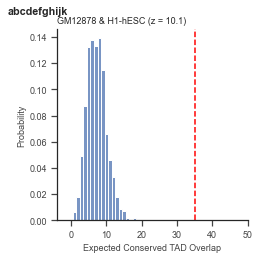

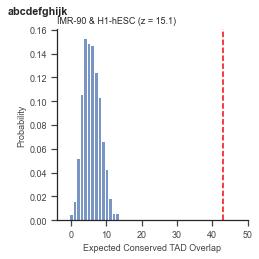

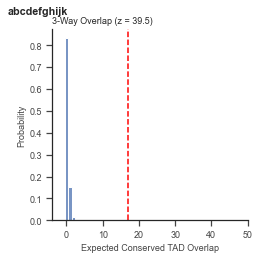

In [83]:
for i, (group, obs) in enumerate(TADOverlap.items()):
    fig, ax = plt.subplots()
    exp = np.array(allShuffles[group])
    z = (obs - exp.mean()) / exp.std()
    sns.histplot(x=exp, stat='probability', discrete=True, ax=ax)
    ax.set_xlabel('Expected Conserved TAD Overlap')
    ax.axvline(obs, color='red', ls='--')
    ax.set_title(f'{group} (z = {z:.1f})', loc='left')
    ax.set_xlim(-4, 50)
    fig.tight_layout()
    ax.text(0, 1, 'abcdefghijk', transform=fig.transFigure, fontsize='large', verticalalignment='top', weight='bold')
    
    if group == 'GM12878 & IMR-90':
        name = 'GM_IM'
    elif group == 'GM12878 & H1-hESC':
        name = 'GM_H1'
    elif group == 'IMR-90 & H1-hESC':
        name = 'IM_H1'
    else:
        name = '3way'
    fig.savefig(f'plots/{name}-TADOverlap.svg')

In [41]:
aAS = aAS.sort().merge()
bAS = bAS.sort().merge()
cAS = cAS.sort().merge()

In [42]:
def getTotalBaseOverlap(a, b, c):
    a_and_b = a.sort().merge().intersect(b, u=True)
    a_and_c = a.sort().merge().intersect(c, u=True).to_dataframe()
    b_and_c = b.sort().merge().intersect(c, u=True).to_dataframe()
    a_and_b_and_c = a_and_b.sort().merge().intersect(c, u=True).to_dataframe()
    a_and_b = a_and_b.to_dataframe()
    
    a_and_b = (a_and_b['end'] - a_and_b['start']).sum()
    a_and_c = (a_and_c['end'] - a_and_c['start']).sum()
    b_and_c = (b_and_c['end'] - b_and_c['start']).sum()
    a_and_b_and_c = (a_and_b_and_c['end'] - a_and_b_and_c['start']).sum()
    return a_and_b, a_and_c, b_and_c, a_and_b_and_c

In [43]:
aAS_and_bAS, aAS_and_cAS, bAS_and_cAS, aAS_and_bAS_and_cAS = getTotalBaseOverlap(aAS, bAS, cAS)

In [44]:
baseOverlap = {}
baseOverlap[f'{formatCell("GM12878")} & {formatCell("IMR90")}'] = aAS_and_bAS
baseOverlap[f'{formatCell("GM12878")} & {formatCell("H1hESC")}'] = aAS_and_cAS
baseOverlap[f'{formatCell("IMR90")} & {formatCell("H1hESC")}'] = bAS_and_cAS
baseOverlap['3-Way Overlap'] = aAS_and_bAS_and_cAS

In [45]:
allShuffles = defaultdict(list)
for i in range(1000):
    aASshuffle = aAS.sort().merge().shuffle(
        g='../hg19.chrom.sizes', incl='../0.getDiffDomain/GM12878-TADs-autosome.bed', noOverlapping=True)
    bASshuffle = bAS.sort().merge().shuffle(
        g='../hg19.chrom.sizes', incl='../0.getDiffDomain/IMR90-TADs-autosome.bed', noOverlapping=True)
    cASshuffle = cAS.sort().merge().shuffle(
        g='../hg19.chrom.sizes', incl='../0.getDiffDomain/H1hESC-TADs-autosome.bed', noOverlapping=True)

    aAS_and_bAS, aAS_and_cAS, bAS_and_cAS, aAS_and_bAS_and_cAS = getTotalBaseOverlap(aASshuffle, bASshuffle, cASshuffle)

    allShuffles[f'{formatCell("GM12878")} & {formatCell("IMR90")}'].append(aAS_and_bAS)
    allShuffles[f'{formatCell("GM12878")} & {formatCell("H1hESC")}'].append(aAS_and_cAS)
    allShuffles[f'{formatCell("IMR90")} & {formatCell("H1hESC")}'].append(bAS_and_cAS)
    allShuffles['3-Way Overlap'].append(aAS_and_bAS_and_cAS)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

0
1
2
3


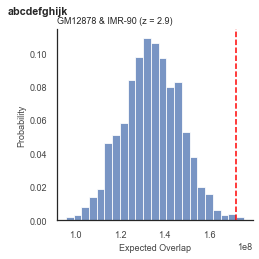

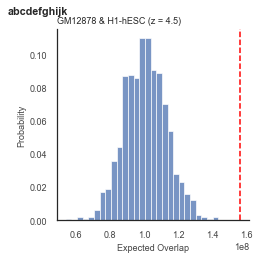

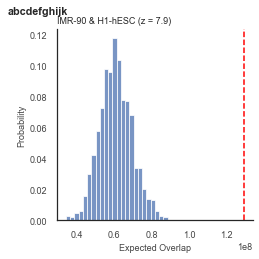

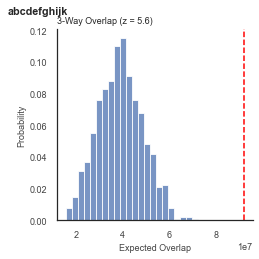

In [48]:
for i, (group, obs) in enumerate(baseOverlap.items()):
    fig, ax = plt.subplots()
    exp = np.array(allShuffles[group])
    z = (obs - exp.mean()) / exp.std()
    sns.histplot(x=exp, stat='probability', ax=ax)
    ax.set_xlabel('Expected Overlap')
    ax.axvline(obs, color='red', ls='--')
    ax.set_title(f'{group} (z = {z:.1f})', loc='left')
    
    fig.tight_layout()
    ax.text(0, 1, 'abcdefghijk', transform=fig.transFigure, fontsize='large', verticalalignment='top', weight='bold')
    if group == 'GM12878 & IMR-90':
        name = 'GM_IM'
    elif group == 'GM12878 & H1-hESC':
        name = 'GM_H1'
    elif group == 'IMR-90 & H1-hESC':
        name = 'IM_H1'
    else:
        name = '3way'
    fig.savefig(f'{name}-BaseOverlap.svg')